<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/aichi/aichi_patients_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tabula-py

     |████████████████████████████████| 11.7MB 333kB/s 


In [ ]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 3.8MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp36-none-any.whl size=4120276 sha256=6d8299f1edd2e311f13cf77adca28f2ec5248b337fa246907da05011290985b3
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib


In [ ]:
import datetime
import hashlib
import pathlib
import re
from urllib.parse import urljoin

In [ ]:
from tabula import read_pdf
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import japanize_matplotlib

In [ ]:
from google.colab import files

In [ ]:
aichi_cities = [
    "名古屋市",
    "一宮市",
    "瀬戸市",
    "春日井市",
    "犬山市",
    "江南市",
    "小牧市",
    "稲沢市",
    "尾張旭市",
    "岩倉市",
    "豊明市",
    "日進市",
    "清須市",
    "北名古屋市",
    "長久手市",
    "東郷町",
    "豊山町",
    "大口町",
    "扶桑町",
    "津島市",
    "愛西市",
    "弥富市",
    "あま市",
    "大治町",
    "蟹江町",
    "飛島村",
    "半田市",
    "常滑市",
    "東海市",
    "大府市",
    "知多市",
    "阿久比町",
    "東浦町",
    "南知多町",
    "美浜町",
    "武豊町",
    "岡崎市",
    "碧南市",
    "刈谷市",
    "豊田市",
    "安城市",
    "西尾市",
    "知立市",
    "高浜市",
    "みよし市",
    "幸田町",
    "豊橋市",
    "豊川市",
    "蒲郡市",
    "新城市",
    "田原市",
    "設楽町",
    "東栄町",
    "豊根村",
]

In [ ]:
ages_list = [
    "10歳未満",
    "10代",
    "20代",
    "30代",
    "40代",
    "50代",
    "60代",
    "70代",
    "80代",
    "90代",
    "100代",
]

In [ ]:
def fetch_file(url, filename):

    p = pathlib.Path(filename)
    p.parent.mkdir(parents=True, exist_ok=True)

    if not p.exists():

        r = requests.get(url)
        r.raise_for_status()

        with p.open(mode="wb") as fw:
            fw.write(r.content)

    return p

In [ ]:
def days2date(s):

    y = 2021 if s.name > 16576 else 2020

    days = re.findall("[0-9]{1,2}", s["発表日"])

    if len(days) == 2:
        m, d = map(int, days)
        return pd.Timestamp(year=y, month=m, day=d)
    else:
        return pd.NaT

# スクレイピング

In [ ]:
url = "https://www.pref.aichi.jp/site/covid19-aichi/"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko"
}

In [ ]:
JST = datetime.timezone(datetime.timedelta(hours=+9), "JST")
dt_now = datetime.datetime.now(JST).replace()

In [ ]:
r = requests.get(url, headers=headers)
r.raise_for_status()

soup = BeautifulSoup(r.content, "html.parser")

# ファイルチェック

In [ ]:
def pdf2df(url, fn):

    fp_pdf = fetch_file(url, fn)
    fp_pkl = fp_pdf.with_suffix(".pkl")
    fp_sha = fp_pdf.with_suffix(".sha256")

    hash = ""
    filename = ""

    # hashファイル確認
    if fp_sha.exists():

        hash, filename = fp_sha.read_text().split()

    checksum = hashlib.sha256(fp_pdf.read_bytes()).hexdigest()

    print(checksum)

    # hashとファイル名とpickle確認
    if (hash == checksum) and (fn == filename) and fp_pkl.exists():

        df = pd.read_pickle(fp_pkl)

    else:
        df = pd.concat(read_pdf(fp_pdf, pages="all", lattice=True))

        df.to_pickle(fp_pkl)
        fp_sha.write_text(f"{checksum} {fn}")

    return df

In [ ]:
tags = soup.find("span", text="▶ 愛知県内の発生事例").parent.find_all("a", href=re.compile(".pdf$"))
links = [urljoin(url, i.get("href")) for i in tags[::-1]]

In [ ]:
df1 = pdf2df(links[0], "source1.pdf")

832e1bbf2fb9b9d7e9bee66c81ee39402569434009bee25c959c020716c98b83


In [ ]:
df2 = pdf2df(links[1], "source2.pdf")

d7108171ead5f44eb2315afcf7f21013be3e278f577a7f36cb7463ceca93a8ff


In [ ]:
df = pd.concat([df1, df2]).set_index("No")

In [ ]:
df.info

<bound method DataFrame.info of          発表日  年代・性別   国籍    住居地         接触状況           備考
No                                                       
1      1月26日  40代男性   中国  中国武漢市           中国        本県発表1
2      1月28日  40代男性   中国  中国武漢市           中国        本県発表2
3      2月14日  60代男性   日本   名古屋市         アメリカ      名古屋市発表1
4      2月15日  60代女性   日本   名古屋市      No.3と接触      名古屋市発表2
5      2月16日  60代男性   日本   尾張地方      No.4と接触        本県発表3
...      ...    ...  ...    ...          ...          ...
24228   2月2日  40代女性  NaN   名古屋市          NaN  名古屋市発表11333
24229   2月2日  70代男性  NaN   名古屋市          NaN  名古屋市発表11334
24230   2月2日  40代男性  NaN   名古屋市  No.23769と接触  名古屋市発表11335
24231   2月2日  30代女性  NaN   名古屋市  No.24008と接触  名古屋市発表11336
24232   2月2日  20代男性  NaN    三重県          NaN  名古屋市発表11337

[24234 rows x 6 columns]>

In [ ]:
df[df["発表日"].isna()]

,発表日,年代・性別,国籍,住居地,接触状況,備考
No,,,,,,
※ 11月10日(火)名古屋市による陽性者公表数の修正,NaN,NaN,NaN,NaN,NaN,NaN
※ 11月10日(火)名古屋市による陽性者公表数の修正,NaN,NaN,NaN,NaN,NaN,NaN


# 前処理

In [ ]:
# 発表日が欠損を削除
df.dropna(subset=["発表日"], inplace=True)

In [ ]:
# Noでソート
df.index = df.index.astype(int)
df.sort_index(inplace=True)

In [ ]:
# 発表日をdatetimeに変換
number_date = df.apply(days2date, axis=1)

In [ ]:
df_date = df["発表日"].str.extract("(\d{1,2})月(\d{1,2})日").rename(columns={0: "month", 1: "day"}).astype(int)
ser = df_date["month"] - df_date["month"].shift(1, fill_value=0)

In [ ]:
# 12から1に変わるとカウント
df_date["year"] = 2020 + (ser == -11).cumsum()

df["発表日"] = pd.to_datetime(df_date)

In [ ]:
# Noと違う日付をチェック
df[df["発表日"] != number_date]

,発表日,年代・性別,国籍,住居地,接触状況,備考
No,,,,,,


In [ ]:
# 未来の日付チェック
df[df["発表日"] > dt_now.replace(tzinfo=None)]

,発表日,年代・性別,国籍,住居地,接触状況,備考
No,,,,,,


In [ ]:
cjk = str.maketrans("⻲⻑黑戶⻯⻄⻘⻤", "亀長黒戸竜西青鬼")

In [ ]:
# 文字コード正規化
df["住居地"] = df["住居地"].fillna("").str.normalize("NFKC")
df["住居地"] = df["住居地"].apply(lambda s: s.translate(cjk))

df["年代・性別"] = df["年代・性別"].str.normalize("NFKC").str.replace(" ", "")

In [ ]:
# 年代と性別を分割
df_ages = df["年代・性別"].str.extract("(.+)(男性|女性|その他)").rename(columns={0: "年代", 1: "性別"})
df = df.join(df_ages)

In [ ]:
# 前後の空白削除
df["年代"] = df["年代"].str.strip()

In [ ]:
df.to_csv("aichi.csv", encoding="utf_8_sig")
# files.download("aichi.csv")

# 抽出

In [ ]:
flag = (
    (df["接触状況"].str.contains("再感染"))
    | (df["住居地"] == "中国武漢市")
    | df.index.isin((1095, 1610, 2085, 2536, 8896, 12906))
)

In [ ]:
flag.sum()

30

In [ ]:
df[flag]

,発表日,年代・性別,国籍,住居地,接触状況,備考,年代,性別
No,,,,,,,,
1,2020-01-26,40代男性,中国,中国武漢市,中国,本県発表1,40代,男性
2,2020-01-28,40代男性,中国,中国武漢市,中国,本県発表2,40代,男性
190,2020-04-02,40代女性,日本,名古屋市,再感染(No.54),名古屋市発表127,40代,女性
356,2020-04-15,20代女性,NaN,名古屋市,再感染(No.35),名古屋市発表204,20代,女性
391,2020-04-18,90代女性,NaN,名古屋市,再感染(No.85),名古屋市発表224,90代,女性
392,2020-04-18,60代男性,NaN,名古屋市,再感染(No.154),名古屋市発表225,60代,男性
491,2020-05-03,60代女性,日本,知多市,再感染(No.353),本県発表197,60代,女性
506,2020-05-14,30代女性,NaN,名古屋市,再感染(No.355),名古屋市発表277,30代,女性
520,2020-06-15,70代男性,NaN,名古屋市,再感染(No.500),名古屋市発表283,70代,男性


In [ ]:
df = df[~flag]

# 陽性者数

In [ ]:
s = df["発表日"].value_counts().sort_index().asfreq("D", fill_value=0)

<BarContainer object of 355 artists>

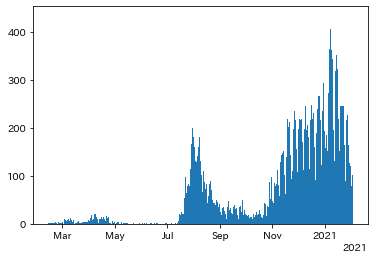

In [ ]:
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.bar(s.index, s, width=1)

In [ ]:
# 直近14日
s.tail(14)

2021-01-20    245
2021-01-21    270
2021-01-22    246
2021-01-23    246
2021-01-24    164
2021-01-25     89
2021-01-26    215
2021-01-27    227
2021-01-28    244
2021-01-29    163
2021-01-30    126
2021-01-31    121
2021-02-01     79
2021-02-02    101
Freq: D, Name: 発表日, dtype: int64

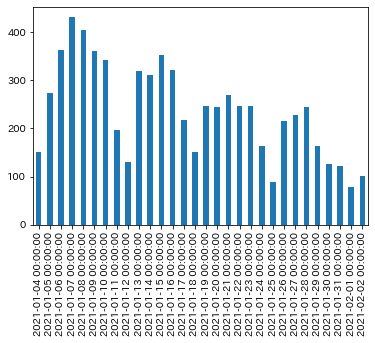

In [ ]:
s.tail(30).plot.bar()

# 住所地

## 県内

In [ ]:
df_kennai = df[df["住居地"].isin(aichi_cities)]

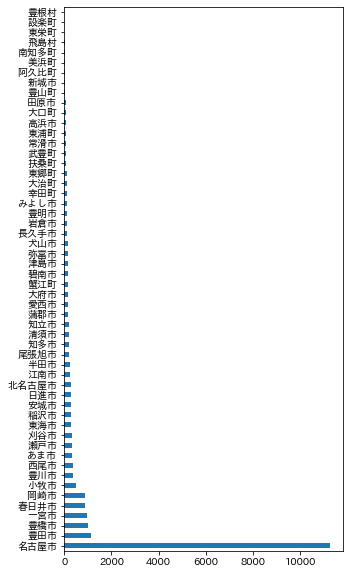

In [ ]:
# 県内
df_kennai["住居地"].value_counts().plot.barh(figsize=(5, 10))

In [ ]:
df_kennai["住居地"].value_counts()

名古屋市     11260
豊田市       1120
豊橋市       1003
一宮市        967
春日井市       887
岡崎市        876
小牧市        489
豊川市        368
西尾市        364
あま市        341
瀬戸市        329
刈谷市        325
東海市        309
稲沢市        292
安城市        284
日進市        269
北名古屋市      269
江南市        264
半田市        255
尾張旭市       218
知多市        214
清須市        207
知立市        193
蒲郡市        181
愛西市        180
大府市        175
蟹江町        168
碧南市        165
津島市        162
弥富市        157
犬山市        140
長久手市       139
岩倉市        134
豊明市        130
みよし市       123
幸田町        114
大治町        110
東郷町         99
扶桑町         96
武豊町         86
常滑市         86
東浦町         86
高浜市         77
大口町         67
田原市         67
豊山町         52
新城市         49
阿久比町        33
美浜町         26
南知多町        24
飛島村         17
東栄町          3
設楽町          2
豊根村          1
Name: 住居地, dtype: int64

In [ ]:
df_kennai.to_csv("kennai.csv", encoding="utf_8_sig")
# files.download("kennai.csv")

## 県外

In [ ]:
df_kengai = df[~df["住居地"].isin(aichi_cities)]

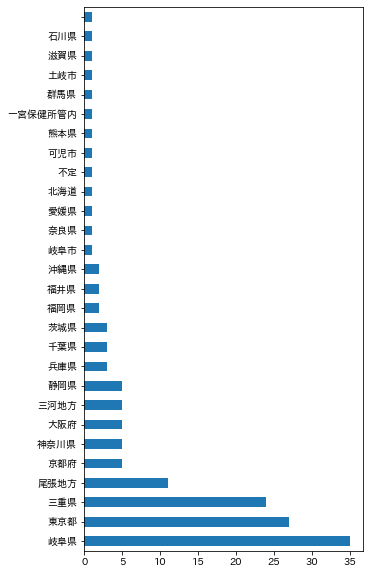

In [ ]:
# 県外
df_kengai["住居地"].value_counts().plot.barh(figsize=(5, 10))

In [ ]:
df_kengai["住居地"].value_counts()

岐阜県        35
東京都        27
三重県        24
尾張地方       11
京都府         5
神奈川県        5
大阪府         5
三河地方        5
静岡県         5
兵庫県         3
千葉県         3
茨城県         3
福岡県         2
福井県         2
沖縄県         2
岐阜市         1
奈良県         1
愛媛県         1
北海道         1
不定          1
可児市         1
熊本県         1
一宮保健所管内     1
群馬県         1
土岐市         1
滋賀県         1
石川県         1
            1
Name: 住居地, dtype: int64

In [ ]:
df_kengai.to_csv("kengai.csv", encoding="utf_8_sig")
# files.download("kengai.csv")

## 置換

In [ ]:
# 県外に置換
df["住居地"] = df["住居地"].where(df["住居地"].isin(aichi_cities), "県外")

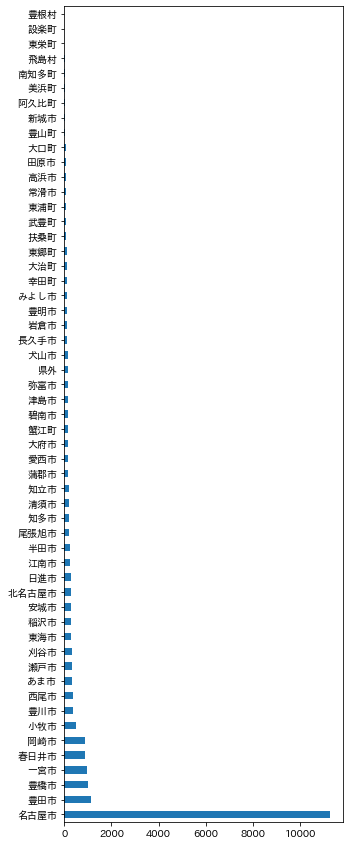

In [ ]:
df["住居地"].value_counts().plot.barh(figsize=(5, 15))

In [ ]:
df["住居地"].value_counts().reindex(aichi_cities, fill_value=0)

名古屋市     11260
一宮市        967
瀬戸市        329
春日井市       887
犬山市        140
江南市        264
小牧市        489
稲沢市        292
尾張旭市       218
岩倉市        134
豊明市        130
日進市        269
清須市        207
北名古屋市      269
長久手市       139
東郷町         99
豊山町         52
大口町         67
扶桑町         96
津島市        162
愛西市        180
弥富市        157
あま市        341
大治町        110
蟹江町        168
飛島村         17
半田市        255
常滑市         86
東海市        309
大府市        175
知多市        214
阿久比町        33
東浦町         86
南知多町        24
美浜町         26
武豊町         86
岡崎市        876
碧南市        165
刈谷市        325
豊田市       1120
安城市        284
西尾市        364
知立市        193
高浜市         77
みよし市       123
幸田町        114
豊橋市       1003
豊川市        368
蒲郡市        181
新城市         49
田原市         67
設楽町          2
東栄町          3
豊根村          1
Name: 住居地, dtype: int64

# 性別

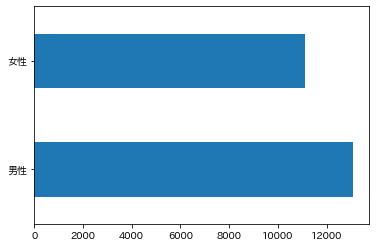

In [ ]:
df["性別"].value_counts().plot.barh()

In [ ]:
# 性別 欠損数
df["性別"].isna().sum()

0

In [ ]:
# 性別
df["性別"].value_counts()

男性    13087
女性    11115
Name: 性別, dtype: int64

# 年代確認

## 置換前

In [ ]:
# ユニーク確認
df["年代"].unique()

array(['60代', '50代', '80代', '70代', '20代', '40代', '30代', '90代', '10歳未満',
       '10代', '100代', '高齢者', 'ー代'], dtype=object)

In [ ]:
df["年代"].value_counts()

20代      5624
30代      3556
40代      3372
50代      3182
60代      2065
70代      2050
10代      1682
80代      1450
10歳未満     790
90代       415
100代       14
ー代          1
高齢者         1
Name: 年代, dtype: int64

## 確認

In [ ]:
# リスト外
df[~df["年代"].isin(ages_list)]

,発表日,年代・性別,国籍,住居地,接触状況,備考,年代,性別
No,,,,,,,,
5543,2020-10-11,高齢者女性,NaN,名古屋市,NaN,名古屋市発表2999,高齢者,女性
13890,2020-12-19,ー代女性,NaN,豊橋市,NaN,豊橋市発表347,ー代,女性


## 置換後 

In [ ]:
# 10歳未満代を10歳未満に置換
df["年代"] = df["年代"].replace("10歳未満代", "10歳未満")

In [ ]:
# リスト外をその他に置換
df["年代"] = df["年代"].where(df["年代"].isin(ages_list), "その他")

In [ ]:
df["年代"].unique()

array(['60代', '50代', '80代', '70代', '20代', '40代', '30代', '90代', '10歳未満',
       '10代', '100代', 'その他'], dtype=object)

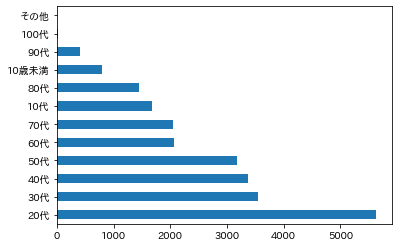

In [ ]:
df["年代"].value_counts().plot.barh()

In [ ]:
df["年代"].value_counts()

20代      5624
30代      3556
40代      3372
50代      3182
60代      2065
70代      2050
10代      1682
80代      1450
10歳未満     790
90代       415
100代       14
その他         2
Name: 年代, dtype: int64

# 市町村別年代

In [ ]:
df_area_ages = pd.crosstab(df["住居地"], df["年代"]).reindex(index=aichi_cities + ["県外"], columns=ages_list + ["その他"], fill_value=0)
df_area_ages

年代,10歳未満,10代,20代,30代,40代,50代,60代,70代,80代,90代,100代,その他
住居地,,,,,,,,,,,,
名古屋市,331,532,2915,1815,1508,1341,973,865,716,253,10,1
一宮市,27,80,190,118,111,151,86,110,84,10,0,0
瀬戸市,9,21,74,53,52,47,24,29,17,3,0,0
春日井市,22,93,180,99,134,133,68,93,57,8,0,0
犬山市,4,26,21,19,22,16,19,9,2,2,0,0
江南市,9,28,45,22,30,47,29,31,20,3,0,0
小牧市,29,55,90,69,81,80,30,30,17,8,0,0
稲沢市,7,22,64,34,39,46,16,41,21,2,0,0
尾張旭市,8,27,53,27,26,26,23,16,11,1,0,0


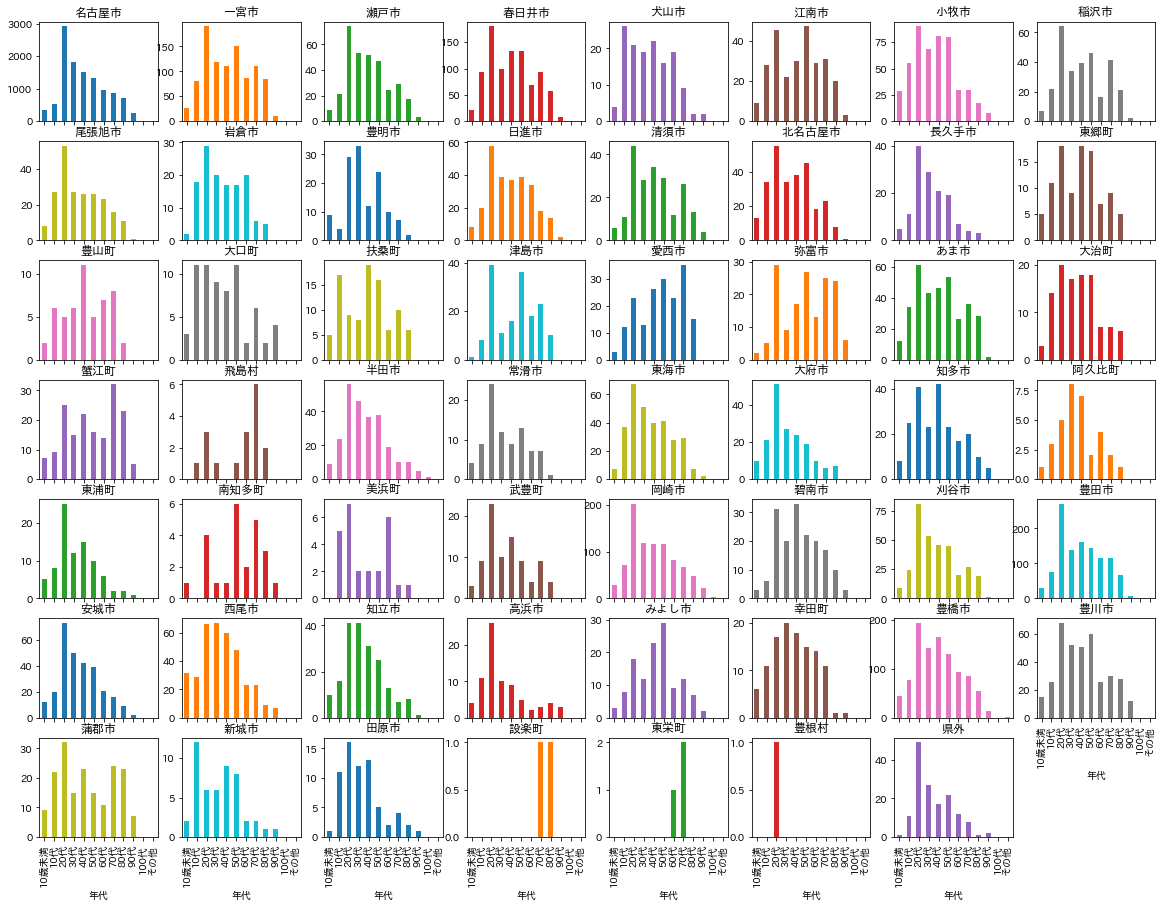

In [ ]:
df_area_ages.T.plot.bar(subplots=True, layout=(7, 8), figsize=(20, 15), legend=False);

In [ ]:
df_area_sex = pd.crosstab(df["住居地"], df["性別"]).reindex(index=aichi_cities + ["県外"], columns=["男性", "女性", "その他"], fill_value=0)
df_area_sex

性別,男性,女性,その他
住居地,,,
名古屋市,6019,5241,0
一宮市,502,465,0
瀬戸市,185,144,0
春日井市,519,368,0
犬山市,72,68,0
江南市,150,114,0
小牧市,249,240,0
稲沢市,164,128,0
尾張旭市,112,106,0


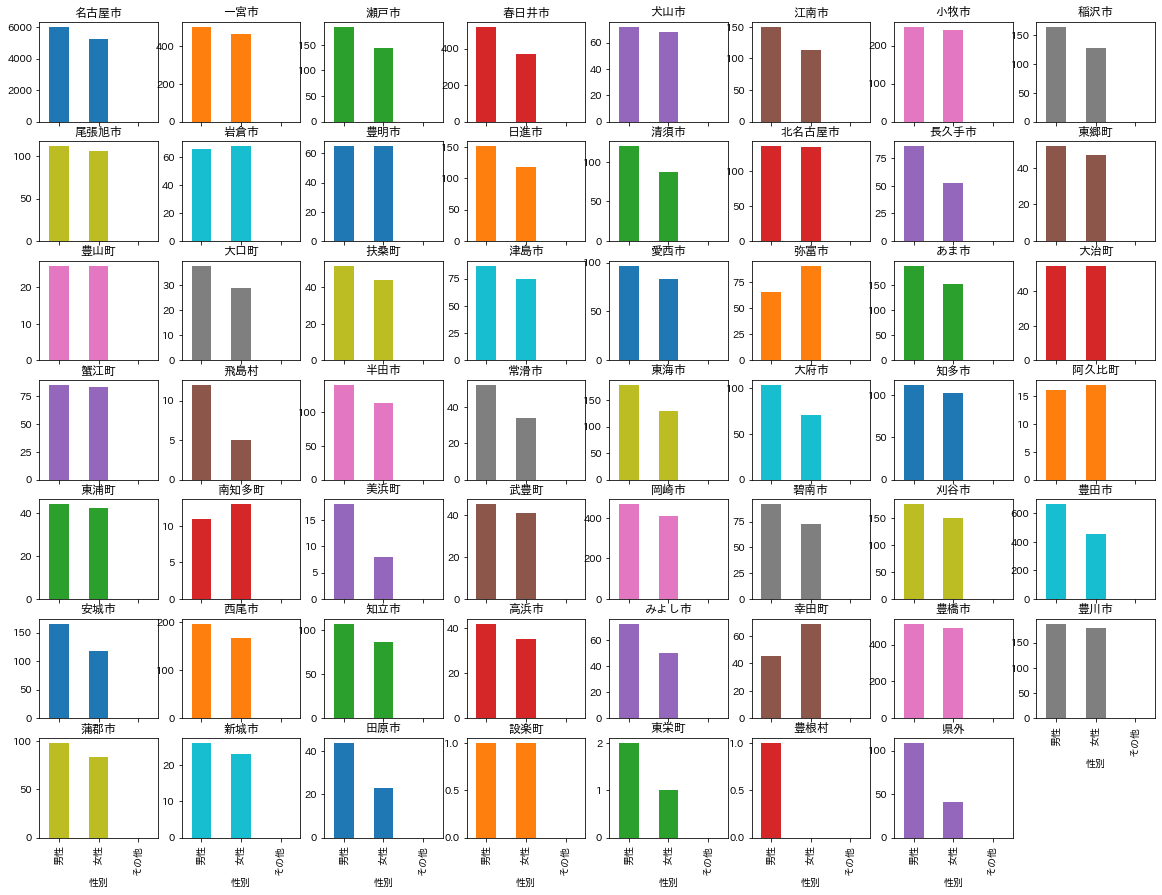

In [ ]:
df_area_sex.T.plot.bar(subplots=True, layout=(7, 8), figsize=(20, 15), legend=False);

# 年代別性別

In [ ]:
df_ages_sex = pd.crosstab(df["年代"], df["性別"]).reindex(index=ages_list + ["その他"], columns=["男性", "女性", "その他"], fill_value=0)
df_ages_sex

性別,男性,女性,その他
年代,,,
10歳未満,398,392,0
10代,921,761,0
20代,2977,2647,0
30代,2012,1544,0
40代,2001,1371,0
50代,1785,1397,0
60代,1207,858,0
70代,1039,1011,0
80代,626,824,0


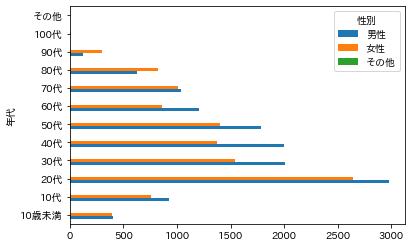

In [ ]:
df_ages_sex.plot.barh()